# Projet Python : reconnaissance de mélanomes 

Louise Blart & Jeanne Astier

## Introduction 

Les grains de beauté, ou *nævus mélanocytaire*, sont des tâches présentes sur la peau. La plupart des grains de beauté sont bénins ; mais certains peuvent évoluter en tumeurs malignes, dans 1 cas pour 100 000 environ. Ils s'agit alors de __mélanomes__, une forme de cancer de la peau.

Comme pour toutes les formes de cancer, un diagnostic précoce augmente l'efficacité du traitement : une mélanome détecté tôt peut être traité facilement, avant que la maladie n'évolue vers une forme mortelle. 

### Problématique

Comment la data science peut-elle aider à la reconnaissance des mélanomes ? 

Ce projet a vocation à __aider au diagnostic de mélanomes__ : nous voulons détecter, parmi un ensemble grains de beauté, lesquels sont malins et présentent un danger pour le patient. Pour ce faire, nous construisons sur algorithme de classification d'images distingant les grains de beauté "malins" et "bénins". 

NB : cette problématique a constitué l'objet d'un [challenge sur la plateforme Kaggle](https://www.kaggle.com/c/siim-isic-melanoma-classification), auquel ont participé plus de 3 000 équipes. Dans la mesure où nous sommes débutantes en machine learning, notre objectif n'est absolument pas de rivaliser avec tous ces participants : nous ne saurions prétendre concurrencer les gagnants d'un tel challenge en termes d'efficacité du diagnostic. Notre approche serait pluôt : comment, en partant de zéro en machine learning, peut-on essayer de traiter des images médicales pour y poser un diagnotic ?

### Plan

Notre projet se décompose en trois parties :
1. [Récupération et traitement des données](#1.-Récupération-et-traitement-des-données)
2. [Analyse de la base](#2.-Analyse-de-la-base)
3. [Modélisation et diagnostic](#3.-Modélisation-et-diagnostic)

### Préalable : téléchargement des modules

In [25]:
# modules classiques 
import numpy as np
import pandas as pd
import csv
import os 
import random

# pour télécharger les données
import urllib.request
from zipfile import ZipFile

# pour la visualisation des données
import matplotlib.pyplot as plt

# modules de traitement d'images
import cv2  
import PIL

# modules de traitement du format DICOM
import pydicom as dicom 
import pydicom.data
from pydicom.pixel_data_handlers.util import convert_color_space 

## 1. Récupération et traitement des données

Nous avons choisi d'effectuer ce projet sur le thème de la reconnaissance de mélanomes pour deux raisons : 
- il s'agit d'une forme de reconnaissance d'images médicales relativement accessible (plus accessible que le traitement d'images médicales comme des scanners ou des IRM par exemple) ;
- une large base d'images de grains de beauté est mise à disposition librement par la SIIM (*Society for Imaging Informatics in Medicine*) et l'ISIC (*International Skin Imaging Collaboration*). 

Le premier enjeu, et pas des moindres, est donc la récupération de ces données et leur traitement pour pouvoir ensuite les exploiter. 

### a) téléchargement des données

Les données sont disponibles [sur le site de l'ISIC](https://challenge2020.isic-archive.com/). Il s'agit de photos de grains de beauté, chacune étant accompagnée de métadonnées (âge et sexe du patient, partie du corps concerncée, etc.). Ces données sont disponibles sous plusieurs formats : 
- au format DICOM (*Digital Imaging and Communications in Medecine*) : il s'agit d'un format standard international pour la gestion informatique des données issues de l'imagerie medicale. Chaque fichier .dcm comprend une image et les métadonnées s'y rapportant. 
- aux formats JPG (pour les images) et CSV (pour les métadonnées) : ces formats sont également proposés par l'ISIC car plus facilement utilisables par le grand public. 

Nous avons fait le choix d'__utiliser des données au format DICOM__ et de les retraiter nous-mêmes pour les adapter à nos besoins. Nous souhaitons en effet inscrie ce projet dans une perspective médicale, en utilisant donc les données telles qu'elles se présentent en imagerie médicale.  


Téléchargement des données DICOM :

( __/!\ attention__ : ces données sont extrêmement volumineuses (presque 50Go). La cellule suivante prend donc prêt de 4h à être exécutée (avec une bonne connexion internet), et requiert de l'espace sur le disque dur où les données seront stockées)


In [18]:
path_dicom = r"D:\DICOM\train"
# dossier dans lequel seront enregistrés les fichiers DICOM

fullfilename = os.path.join(path_dicom, "DICOM.zip")

urllib.request.urlretrieve("https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_Dicom.zip", fullfilename)

print ('Le téléchargement est terminé !')

Le téléchargement est terminé !


Dézippage du fichier :

( __/!\ attention__ : là encore, les données étant très volumineuses, le dézippage peut être long. Exécuter la cellule suivante peut donc prendre quelques heures). 

In [19]:
with ZipFile(fullfilename, 'r') as zip: 
    zip.extractall(path_dicom) 
    print("L'extraction est terminée !") 

L'extraction est terminée !


Nous disposons maintenant de 33 106 images de grains de beauté avec leurs métadonnées associées. 

Une information nous manque encore cependant pour chaque image : son diagnostic (grain de beauté malin ou bénin). Cette information se situe dans un fichier CSV complémentaire, que nous téléchargons donc échalement : 

In [24]:
path_csv = r"C:\Users\jeann\OneDrive\Documents\scolaire\ENSAE\2A\S1\python\projet"
# dossier dans lequel sera enreigtré de fichier CSV

fullfilename = os.path.join(path_csv, "train.csv")

urllib.request.urlretrieve("https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth.csv", fullfilename)

print ('Le téléchargement est terminé !')

Le téléchargement est terminé !


### b) traitement des données

Maintenant que nous avons téléchargé toutes les données, nous pouvons commencer à les explorer - en particulier regarder comment se présente le format DICOM (format des images). 

In [52]:
# on choisit un fichier DICOM au hasard pour regarder sa structure 
path_dicom = r"D:\DICOM\train"
files = os.listdir(path_dicom)
i = random.randint(0, len(files))
file = files[i]

In [53]:
# affichage des métadonnées associées à l'image
filename = pydicom.data.data_manager.get_files(path_dicom, file)[0]
ds = pydicom.dcmread(filename)
print(ds) 

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 220
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.99.1.8465.1063.1589984470169.1.1.0.0.0
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.99.2
(0002, 0013) Implementation Version Name         SH: 'PIXELMEDJAVA001'
(0002, 0016) Source Application Entity Title     AE: 'OURAETITLE'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.99.3
(0008, 0016) SOP Class UID                       UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0008, 0018) SOP Instance UID                    UI: 

On constate que les métadonnées sont très nombreuses ; mais seules quelques-unes nous intéressent : 

In [54]:
print("image :", file)
print("nom du patient :", ds.PatientName)
print("âge du patient :", ds.PatientAge)
print("sexe du patient :", ds.PatientSex)
print("prtie du corps : ", ds.BodyPartExamined)

image : ISIC_8608270.dcm
nom du patient : "ISIC^8608270"
âge du patient : 050Y
sexe du patient : F
prtie du corps :  LOWER EXTREMITY


On peut enfin afficher l'image en tant que telle : 

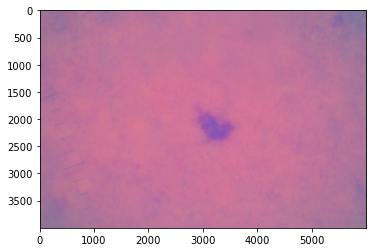

In [55]:
plt.imshow(ds.pixel_array) 

On constate que les couleurs de l'image n'ont pas l'air naturelles : il faut changer leur format de couleur pour avoir une aperçu des couleurs "naturelles" (format RGB). 
        

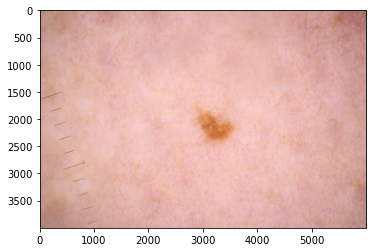

In [56]:
initial_color = ds.PhotometricInterpretation
convert = convert_color_space(ds.pixel_array, initial_color, 'RGB')
plt.imshow(convert)

Comme nous venons de le voir, le format DICOM peut être manipulé sur python à l'aide du module "pydicom". Cependant, ce format ne nous apparaît pas comme le plus facilement manipulable : nous préférons donc convertir ces données dans un format avec lequel nous sommes plus à l'aise. 

Deux étapes dans le traitement des données : 
- l'extraction des métadonnées de chaque fichier DICOM, pour les insérer dans un dataframe. 
- l'extraction des images de chaque fichier DICOM, pour les enregistrer au format JPG. 

Pour ce faire, nous créons la classe suivante :

In [26]:
class Dataframe :
    def __init__(self):
        self.path_dicom = r"D:\DICOM\train" 
        # Chemin vers le dossier contenant des fichiers DICOM
        self.path_Training_GroundTruth = r"C:\Users\jeann\OneDrive\Documents\scolaire\ENSAE\2A\S1\python\projet\train.csv" 
        # Chemin vers les données de diagnostic
        self.path_jpg = r"D:\JPG" 
        # Chemin vers le dossier qui contiendra les images JPG
        self.path_jpg_RGB= r"D:\JPG_RGB" 
        # Chemin vers le dossier qui contiendra les images JPG aux couleurs RGB
        self.columns =["image_id", "patient_age", "patient_sex", "body_part"] 
        # informations qu'on désire récupérer dans les données DICOM
                    
        
    def from_DICOM_to_DF(self):
        '''
        Cette fonction crée et remplit un dataframe a partir de quelques-unes des informations présentes dans les metadonnees 
        DICOM. Le format DICOM peut etre traité par Python, mais nous sommes beaucoup plus à l'aise avec un dataframe et
        nous n'avons pas besoin de toutes les informations contenues dans les métadonnées DICOM. 
        
        Cette fonction :
            - prend en paramètre "self" permettant d'aller chercher les informations dans la partie init         
            - renvoie : le dataframe comprenant les informations extraites  
            
        Exemple : 
            w = Dataframe()
            w.from_DICOM_to_DF()
        '''
        
        global df
        df = pd.DataFrame(columns=self.columns)
        for file in os.listdir(self.path_dicom) : 
            filename = pydicom.data.data_manager.get_files(self.path_dicom, file)[0]
            ds = pydicom.dcmread(filename)
            values = [ds.PatientID[1:-1], int(ds.PatientAge[:3]), ds.PatientSex, ds.BodyPartExamined] 
            df_new_row = pd.DataFrame(data = [values], columns = self.columns)
            df = pd.concat([df, df_new_row], ignore_index = True)
        df2 = pd.read_csv(self.path_Training_GroundTruth) 
        # on va chercher dans le fichier csv  l'information target (bénin ou malin) et le patient_id
        df = pd.merge(df,df2[['image_name','target', "patient_id"]], left_on='image_id', right_on='image_name')
        return df
    

    def convert_DICOM_to_JPG (self) :
        '''
        Cette fonction permet de convertir un dossier dont les images sont sous le format DICOM (Digital imaging and 
        communications in medecine) en format JPG.
        Python est capable de traiter les donnees au format .dcm ;cependant, pour ouvrir plus facilement les images
        individuellement sans devoir installer de nouveaux logiciels sur nos ordinateurs, il est plus pratique de convertir
        ces images dans sous un format plus commun.  
    
        Cette fonction :
            - prend en parametres "self" permettant d'aller chercher les informations dans la partie init
            - renvoie : le dossier où les images.jpg sont enregistrees  
            
        Exemple : 
            w = Dataframe()
            w.convert_DICOM_to_JPG()
        '''
        
        images_path = os.listdir(self.path_dicom) 
        for n, image in enumerate(images_path):
            ds = pydicom.dcmread(os.path.join(self.path_dicom, image)) 
            # lire un fichier dicom a partir d'un chemin de dossier et un nom de fichier
            pixel_array_numpy = ds.pixel_array 
            # données sur les pixels, i.e. l'image en tant que telle
            image = image.replace('.dcm', '.jpg')
            cv2.imwrite(os.path.join(self.path_jpg, image), pixel_array_numpy) # enregistrer l'image
        print ('Le dossier est pret ! ')
    
 
    def convert_to_JPG_RGB (self) : 
        ''''
        Cette fonction permet de convertir les images d'un dossier au format DICOM (Digital imaging and communications 
        in medecine) et au format de couleurs "YBR_FULL_422", en images au format JPG et au format de couleurs "RGB" 
        (ce qui permet d'avoir un rendu plus "naturel" de l'image).
       
        Cette fonction :
            - prend en parametres "self" permettant d'aller chercher les informations dans la partie init
            - renvoie : Le dossier ou les images.jpg et rgb sont enregistrées  
    
        Exemple : 
            w = Dataframe()
            w.convert_to_JPG_RGB()
        '''    
        
        images_path = os.listdir(self.path_dicom) 
        for n, image in enumerate(images_path) : 
            ds = pydicom.dcmread(os.path.join(self.path_dicom, image))
            convert = convert_color_space(ds.pixel_array, 'YBR_FULL_422', 'RGB')
            image = image.replace('.dcm', '.jpg') 
            cv2.imwrite(os.path.join(self.path_jpg_RGB, image), cv2.cvtColor(convert, cv2.COLOR_RGB2BGR))
        print ('Le dossier est pret !')


Nous traitons maintenant l'ensemble des fichiers DICOM téléchargés pour les insérer dans le dataframe des métadonnées. 

( __/!\ attention__ : là encore, la cellule suivant peut prendre plusieurs heures à tourner. Le programe doit en effet passer en revue quelques 33 106 fichiers pour en extraire des données, ce qui peut être un peu long).

In [27]:
w = Dataframe()
df = w.from_DICOM_to_DF()
df.head(100)

,image_id,patient_age,patient_sex,body_part,image_name,target,patient_id
0,ISIC_0015719,40,F,UPPER EXTREMITY,ISIC_0015719,0,IP_3075186
1,ISIC_0052212,50,F,LOWER EXTREMITY,ISIC_0052212,0,IP_2842074
2,ISIC_0068279,45,F,HEAD/NECK,ISIC_0068279,0,IP_6890425
3,ISIC_0074268,55,F,UPPER EXTREMITY,ISIC_0074268,0,IP_8723313
4,ISIC_0074311,40,F,LOWER EXTREMITY,ISIC_0074311,0,IP_2950485
...,...,...,...,...,...,...,...
95,ISIC_0151200,25,F,TORSO,ISIC_0151200,0,IP_5549010
96,ISIC_0152307,35,M,TORSO,ISIC_0152307,0,IP_6977878
97,ISIC_0152823,40,F,LOWER EXTREMITY,ISIC_0152823,0,IP_6885799
98,ISIC_0153265,35,F,TORSO,ISIC_0153265,0,IP_2838638


Comme cette étape de création et de remplissage du datagrame complet est très très longue, nous préférons éviter de devoir la relancer à chaque nouvelle ouverture du projet ; aussi enregistrons-nous ce dataframe au format csv, pour pouvoir ensuite l'ouvrir plus facilement et rapidement. 

In [32]:
df.to_csv(r"C:\Users\jeann\OneDrive\Documents\scolaire\ENSAE\2A\S1\python\projet\base_complete.csv", index = False)

## 2. Analyse de la base

In [59]:
df_train = pd.read_csv(r"C:\Users\jeann\OneDrive\Documents\scolaire\ENSAE\2A\S1\python\projet\base_complete.csv")